<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/lstm/CA_TimeSeries_LSTM_PCA_SupersetData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This colab finds the possible 'New Cases' in some counties in California after PCA analysis 

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 CA_alldatasets_Feb05.csv
 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb05.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb06.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_combined_Feb04.csv
 CA_CovidDataJan10.csv
 CA_dataset_Feb11.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb05.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb06.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Feb04.csv
 CA_processedMarylandData_Feb05.csv
 CA_processedMarylandData_Feb12.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 CA_socialDistancingInertiaData_Feb04.csv
 CA_Superset_dataset_Feb12.csv
 computed_CA_mobility_data.csv
 data-mask_for_all.csv
 election_results_2021.csv
 maryland_inertia_data_allstates_Feb04.csv
 maryland_inertia_data_allstates_Feb05.csv
 maryland_inertia_data_allstates_Feb12.csv
 maryland_inertia_data_allstates_Jan11.csv
 maryland_inertia_raw_dec28_2020.csv
 Mask_Rule_Feb05.cs

In [ ]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error,precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import median_absolute_error, mean_absolute_error


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load superset data for CA

In [ ]:
CA_superset_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_SuperData_Labeled_CDCGuideline_Feb13.csv',low_memory=False)
CA_superset_data.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New cases/100k,positivity_rate,rolling_avg_new_cases/100k,growth_label
0,2020-03-01,California,6001,0,Alameda County,0.0000,3.6840,58,6.0000,9.0000,15.0000,1.0000,4.0000,0.0000,860.7571,California,CA,6001,Alameda County,6,37,26,2.9300,25.4000,0.4000,36.8000,0.2500,2.6800,0,1666753,-5.1000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,0.0000,0.0000,0.0000,37,54.0000,0.0000,0.0000,0.0000,0,0,0.0500,35,1.1000,5.3000,5.7000,0.6000,0.0000,0.0000,0.0000,0.0000,minimal
1,2020-03-02,California,6001,0,Alameda County,0.0000,6.1820,98,4.0000,7.0000,7.0000,-1.0000,3.0000,0.0000,860.7571,California,CA,6001,Alameda County,6,17,20,3.3800,28.2000,0.4000,38.1000,0.6300,2.7400,0,1666753,-2.9000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,0.0000,0.0000,0.0000,38,54.0000,0.0000,0.0000,0.0000,0,0,0.0500,35,1.1000,5.3000,5.7000,0.6000,0.0000,0.0000,0.0000,0.0000,minimal
2,2020-03-03,California,6001,1,Alameda County,0.0000,6.2710,100,5.0000,12.0000,41.0000,0.0000,1.0000,-1.0000,860.7571,California,CA,6001,Alameda County,6,16,18,3.6100,27.1000,0.3000,32.7000,0.6700,2.9400,1,1666753,4.1000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,0.0000,0.0002,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,1,0.0500,42,1.1000,5.3000,5.7000,0.6000,0.0000,0.0600,0.0000,0.0000,minimal
3,2020-03-04,California,6001,0,Alameda County,0.0000,6.2090,99,1.0000,6.0000,23.0000,-3.0000,1.0000,0.0000,860.7571,California,CA,6001,Alameda County,6,14,18,3.5500,27.9000,0.3000,36.9000,0.6800,2.8700,0,1666753,1.7000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,0.0000,0.0002,0.0000,0,54.0000,10.3000,0.0100,0.0000,0,1,0.0600,42,1.1000,5.3000,5.7000,0.6000,0.0400,0.0000,0.0020,0.0000,minimal
4,2020-03-05,California,6001,0,Alameda County,0.0000,6.6540,106,1.0000,6.0000,12.0000,-5.0000,-1.0000,1.0000,860.7571,California,CA,6001,Alameda County,6,15,19,3.5400,28.1000,0.3000,36.8000,0.6600,2.8800,0,1666753,2.0000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,0.0000,0.0002,0.0000,0,54.0000,10.3000,0.0100,0.0000,0,1,0.0600,42,1.1000,5.3000,5.7000,0.6000,0.0400,0.0000,0.0020,0.0000,minimal


## Group the data

In [ ]:
CA_superset_data['growth_code'] = CA_superset_data['growth_label'].astype('category').cat.codes
CA_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New cases/100k,positivity_rate,rolling_avg_new_cases/100k,growth_label,growth_code
0,2020-03-01,California,6001,0,Alameda County,0.0000,3.6840,58,6.0000,9.0000,15.0000,1.0000,4.0000,0.0000,860.7571,California,CA,6001,Alameda County,6,37,26,2.9300,25.4000,0.4000,36.8000,0.2500,2.6800,0,1666753,-5.1000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,0.0000,0.0000,0.0000,37,54.0000,0.0000,0.0000,0.0000,0,0,0.0500,35,1.1000,5.3000,5.7000,0.6000,0.0000,0.0000,0.0000,0.0000,minimal,0
1,2020-03-02,California,6001,0,Alameda County,0.0000,6.1820,98,4.0000,7.0000,7.0000,-1.0000,3.0000,0.0000,860.7571,California,CA,6001,Alameda County,6,17,20,3.3800,28.2000,0.4000,38.1000,0.6300,2.7400,0,1666753,-2.9000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,0.0000,0.0000,0.0000,38,54.0000,0.0000,0.0000,0.0000,0,0,0.0500,35,1.1000,5.3000,5.7000,0.6000,0.0000,0.0000,0.0000,0.0000,minimal,0


In [ ]:
CA_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'State', 'CTFIPS', 'CTNAME', 'STFIPS', 'Social.distancing.index',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'New.COVID.cases', 'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.peop

## Below are the segmented columns as per category

In [ ]:
x_col_demographics = ['FIPS','PopDensity','X..people.older.than.60',
                      'Median.income', 'X..African.Americans',
                      'X..Hispanic.Americans', 'X..Male','Date','New cases/100k']

x_col_demographics_feature_imp = ['X..people.older.than.60','Median.income','X..Male',
                                 'FIPS','X..African.Americans','Date','New cases/100k']

In [ ]:
x_col_hospitalization_testing = ['Hospital.beds.1000.people',
       'ICUs.1000.people', 
       'X..hospital.bed.utilization',
       'Testing.capacity', 'Tests.done.1000.people', 'X..ICU.utilization',
       'Ventilator.shortage','positivity_rate',
       'rolling_avg_new_cases/100k'	,'growth_code','Date','New cases/100k'] #'X..contact.tracing.workers.1000.people',

x_col_hospitalization_feature_imp = ['X..hospital.bed.utilization','positivity_rate','Ventilator.shortage',
                                     'positivity_rate','Testing.capacity','growth_code',
                                     'rolling_avg_new_cases/100k','Date','New cases/100k']


In [ ]:
x_col_mobility = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person','X..working.from.home','Date','New cases/100k']

x_col_mobility_feature_imp = ['retail_and_recreation_percent_change_from_baseline','Trips.person',
                              'X..working.from.home','parks_percent_change_from_baseline',
                              'X..out.of.county.trips',
                              'X..out.of.state.trips','X..working.from.home','Miles.person',
                              'grocery_and_pharmacy_percent_change_from_baseline','transit_stations_percent_change_from_baseline',
                              'retail_and_recreation_percent_change_from_baseline','Date','New cases/100k']

In [ ]:
x_col_socialdistancing = ['m50', 'm50_index','Social.distancing.index','Date','New cases/100k']

In [ ]:
x_col_maskrule = ['mask_rule_severity','Date','New cases/100k']

# LSTM: Demographic Group

In [ ]:
X_cols_all = x_col_demographics

X_cols_feature_selected = x_col_demographics_feature_imp

In [ ]:
LA_combined_data_all = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_featured = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_feature_selected]
print(LA_combined_data_featured.shape)
LA_combined_data_all.head(5)

(292, 9)
(292, 7)


,FIPS,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Date,New cases/100k
4804,6037,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-01,0.0000
4805,6037,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-02,0.0000
4806,6037,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-03,0.0000
4807,6037,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-04,0.0594
4808,6037,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-05,0.0396


In [ ]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [ ]:
len(LA_combined_data_featured.columns)

7

In [ ]:
LA_combined_data_featured['Date'] = LA_combined_data_featured['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_all['Date'] = LA_combined_data_all['Date'].apply(lambda x: datetime_to_float(x))

#Harris_combined_data.index.name = 'Date'
LA_combined_data_featured.head()

,X..people.older.than.60,Median.income,X..Male,FIPS,X..African.Americans,Date,New cases/100k
4804,18,64251,49.2800,6037,7.9000,1583020800.0000,0.0000
4805,18,64251,49.2800,6037,7.9000,1583107200.0000,0.0000
4806,18,64251,49.2800,6037,7.9000,1583193600.0000,0.0000
4807,18,64251,49.2800,6037,7.9000,1583280000.0000,0.0594
4808,18,64251,49.2800,6037,7.9000,1583366400.0000,0.0396


In [ ]:
print(len(LA_combined_data_featured.columns))
LA_combined_data_featured.dtypes

7


X..people.older.than.60      int64
Median.income                int64
X..Male                    float64
FIPS                         int64
X..African.Americans       float64
Date                       float64
New cases/100k             float64
dtype: object

## Preprocessing data for LSTM

In [ ]:
LA_combined_data_all_selected = LA_combined_data_all[X_cols_all]
LA_combined_data_featured_selected = LA_combined_data_featured[X_cols_feature_selected]

In [ ]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## All values for CA training data

In [ ]:
values = LA_combined_data_all_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_all)-1] = encoder.fit_transform(values[:,len(X_cols_all)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t)  var8(t)  var9(t)
1     0.0000     0.0000     0.0000  ...   0.0000   0.0033   0.0000
2     0.0000     0.0000     0.0000  ...   0.0000   0.0066   0.0000
3     0.0000     0.0000     0.0000  ...   0.0000   0.0099   0.0186
4     0.0000     0.0000     0.0000  ...   0.0000   0.0132   0.0112
5     0.0000     0.0000     0.0000  ...   0.0000   0.0166   0.0074

[5 rows x 18 columns]


## Train Test Split

In [ ]:
values.shape[0]

292

In [ ]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 18)
(232, 1, 17) (232,) (59, 1, 17) (59,)


## Training LSTM

Epoch 1/100
4/4 - 3s - loss: 0.4098 - val_loss: 0.7788
Epoch 2/100
4/4 - 0s - loss: 0.3857 - val_loss: 0.7408
Epoch 3/100
4/4 - 0s - loss: 0.3625 - val_loss: 0.7027
Epoch 4/100
4/4 - 0s - loss: 0.3402 - val_loss: 0.6645
Epoch 5/100
4/4 - 0s - loss: 0.3188 - val_loss: 0.6259
Epoch 6/100
4/4 - 0s - loss: 0.2982 - val_loss: 0.5870
Epoch 7/100
4/4 - 0s - loss: 0.2788 - val_loss: 0.5489
Epoch 8/100
4/4 - 0s - loss: 0.2601 - val_loss: 0.5109
Epoch 9/100
4/4 - 0s - loss: 0.2421 - val_loss: 0.4731
Epoch 10/100
4/4 - 0s - loss: 0.2253 - val_loss: 0.4357
Epoch 11/100
4/4 - 0s - loss: 0.2111 - val_loss: 0.3999
Epoch 12/100
4/4 - 0s - loss: 0.1996 - val_loss: 0.3666
Epoch 13/100
4/4 - 0s - loss: 0.1910 - val_loss: 0.3369
Epoch 14/100
4/4 - 0s - loss: 0.1852 - val_loss: 0.3124
Epoch 15/100
4/4 - 0s - loss: 0.1810 - val_loss: 0.2925
Epoch 16/100
4/4 - 0s - loss: 0.1782 - val_loss: 0.2772
Epoch 17/100
4/4 - 0s - loss: 0.1763 - val_loss: 0.2670
Epoch 18/100
4/4 - 0s - loss: 0.1750 - val_loss: 0.2607
E

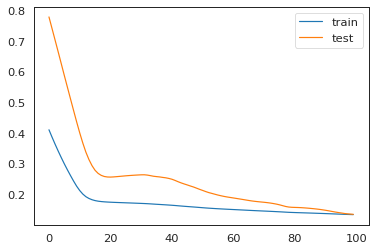

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


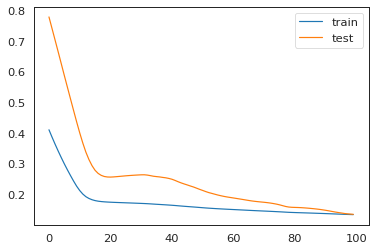

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [ ]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 17)
Test MSE: 0.042
Test RMSE: 0.204
median_absolute_error 0.09818667
mean_absolute_error 0.13332893


## Preprocessing feature selected data for training

In [ ]:
len(LA_combined_data_featured_selected.columns)

7

In [ ]:
values = LA_combined_data_featured_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_feature_selected)-1] = encoder.fit_transform(values[:,len(X_cols_feature_selected)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var5(t)  var6(t)  var7(t)
1     0.0000     0.0000     0.0000  ...   0.0000   0.0033   0.0000
2     0.0000     0.0000     0.0000  ...   0.0000   0.0066   0.0000
3     0.0000     0.0000     0.0000  ...   0.0000   0.0099   0.0186
4     0.0000     0.0000     0.0000  ...   0.0000   0.0132   0.0112
5     0.0000     0.0000     0.0000  ...   0.0000   0.0166   0.0074

[5 rows x 14 columns]


### Train Test split

In [ ]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 14)
(232, 1, 13) (232,) (59, 1, 13) (59,)


### Training LSTM for feature selected data

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/200
4/4 - 3s - loss: 0.3897 - val_loss: 0.7331
Epoch 2/200
4/4 - 0s - loss: 0.3665 - val_loss: 0.6959
Epoch 3/200
4/4 - 0s - loss: 0.3445 - val_loss: 0.6585
Epoch 4/200
4/4 - 0s - loss: 0.3237 - val_loss: 0.6211
Epoch 5/200
4/4 - 0s - loss: 0.3039 - val_loss: 0.5834
Epoch 6/200
4/4 - 0s - loss: 0.2849 - val_loss: 0.5466
Epoch 7/200
4/4 - 0s - loss: 0.2667 - val_loss: 0.5099
Epoch 8/200
4/4 - 0s - loss: 0.2496 - val_loss: 0.4742
Epoch 9/200
4/4 - 0s - loss: 0.2346 - val_loss: 0.4399
Epoch 10/200
4/4 - 0s - loss: 0.2215 - val_loss: 0.4069
Epoch 11/200
4/4 - 0s - loss: 0.2100 - val_loss: 0.3755
Epoch 12/200
4/4 - 0s - loss: 0.2014 - val_loss: 0.3479
Epoch 13/200
4/4 - 0s - loss: 0.1948 - val_loss: 0.3246
Epoch 14/200
4/4 - 0s - loss: 0.1901 - val_loss: 0.3053
Epoch 15/200
4/4 - 0s - loss: 0.1867 - val_loss: 0.2895
Epoch 16/200
4/4 - 0s - loss: 0.1844 - val_loss: 0.2778
Epoch 17/200
4/4 - 0s - loss: 0.1828 - val_loss: 0.2702
Epoch 18/200
4/4 - 0s - loss: 0.1817 - val_loss: 0.2657
E

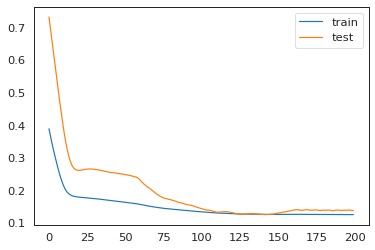

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing feature selected data

In [ ]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 13)
Test MSE: 0.049
Test RMSE: 0.220
median_absolute_error 0.090957284
mean_absolute_error 0.13854092


# LSTM: Hospitalization and testing Group

In [ ]:


X_cols_all = x_col_hospitalization_testing

X_cols_feature_selected = x_col_hospitalization_feature_imp


In [ ]:
LA_combined_data_all = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_featured = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_feature_selected]
print(LA_combined_data_featured.shape)
LA_combined_data_all.head(5)

(292, 12)
(292, 9)


,Hospital.beds.1000.people,ICUs.1000.people,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,positivity_rate,rolling_avg_new_cases/100k,growth_code,Date,New cases/100k
4804,2.0500,0.2200,54.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0,2020-03-01,0.0000
4805,2.0500,0.2200,54.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0,2020-03-02,0.0000
4806,2.0500,0.2200,54.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0,2020-03-03,0.0000
4807,2.0500,0.2200,54.0000,10.3000,0.0100,0.0000,0,0.0020,0.0000,0,2020-03-04,0.0594
4808,2.0500,0.2200,54.0000,10.3000,0.0100,0.0000,0,0.0030,0.0000,0,2020-03-05,0.0396


In [ ]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [ ]:
len(LA_combined_data_featured.columns)

9

In [ ]:
LA_combined_data_featured['Date'] = LA_combined_data_featured['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_all['Date'] = LA_combined_data_all['Date'].apply(lambda x: datetime_to_float(x))

#Harris_combined_data.index.name = 'Date'
LA_combined_data_featured.head()

,X..hospital.bed.utilization,positivity_rate,Ventilator.shortage,positivity_rate,Testing.capacity,growth_code,rolling_avg_new_cases/100k,Date,New cases/100k
4804,54.0000,0.0000,0,0.0000,0.0000,0,0.0000,1583020800.0000,0.0000
4805,54.0000,0.0000,0,0.0000,0.0000,0,0.0000,1583107200.0000,0.0000
4806,54.0000,0.0000,0,0.0000,0.0000,0,0.0000,1583193600.0000,0.0000
4807,54.0000,0.0020,0,0.0020,10.3000,0,0.0000,1583280000.0000,0.0594
4808,54.0000,0.0030,0,0.0030,10.3000,0,0.0000,1583366400.0000,0.0396


In [ ]:
print(len(LA_combined_data_featured.columns))
LA_combined_data_featured.dtypes

9


X..hospital.bed.utilization    float64
positivity_rate                float64
Ventilator.shortage              int64
positivity_rate                float64
Testing.capacity               float64
growth_code                       int8
rolling_avg_new_cases/100k     float64
Date                           float64
New cases/100k                 float64
dtype: object

## Preprocessing data for LSTM

In [ ]:
LA_combined_data_all_selected = LA_combined_data_all[X_cols_all]
LA_combined_data_featured_selected = LA_combined_data_featured[X_cols_feature_selected]

In [ ]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## All values for CA training data

In [ ]:
values = LA_combined_data_all_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_all)-1] = encoder.fit_transform(values[:,len(X_cols_all)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var10(t)  var11(t)  var12(t)
1     0.0000     0.0000     0.0000  ...    0.0000    0.0033    0.0000
2     0.0000     0.0000     0.0000  ...    0.0000    0.0066    0.0000
3     0.0000     0.0000     0.0000  ...    0.0000    0.0099    0.0186
4     0.0000     0.0000     0.0000  ...    0.0000    0.0132    0.0112
5     0.0000     0.0000     0.0000  ...    0.0000    0.0166    0.0074

[5 rows x 24 columns]


## Train Test Split

In [ ]:
values.shape[0]

292

In [ ]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 24)
(232, 1, 23) (232,) (59, 1, 23) (59,)


## Training LSTM

Epoch 1/100
4/4 - 3s - loss: 0.3761 - val_loss: 0.7100
Epoch 2/100
4/4 - 0s - loss: 0.3303 - val_loss: 0.6254
Epoch 3/100
4/4 - 0s - loss: 0.2898 - val_loss: 0.5447
Epoch 4/100
4/4 - 0s - loss: 0.2549 - val_loss: 0.4644
Epoch 5/100
4/4 - 0s - loss: 0.2242 - val_loss: 0.3857
Epoch 6/100
4/4 - 0s - loss: 0.2001 - val_loss: 0.3123
Epoch 7/100
4/4 - 0s - loss: 0.1819 - val_loss: 0.2449
Epoch 8/100
4/4 - 0s - loss: 0.1692 - val_loss: 0.1995
Epoch 9/100
4/4 - 0s - loss: 0.1600 - val_loss: 0.1784
Epoch 10/100
4/4 - 0s - loss: 0.1534 - val_loss: 0.1674
Epoch 11/100
4/4 - 0s - loss: 0.1483 - val_loss: 0.1663
Epoch 12/100
4/4 - 0s - loss: 0.1441 - val_loss: 0.1682
Epoch 13/100
4/4 - 0s - loss: 0.1401 - val_loss: 0.1712
Epoch 14/100
4/4 - 0s - loss: 0.1363 - val_loss: 0.1745
Epoch 15/100
4/4 - 0s - loss: 0.1327 - val_loss: 0.1779
Epoch 16/100
4/4 - 0s - loss: 0.1292 - val_loss: 0.1813
Epoch 17/100
4/4 - 0s - loss: 0.1258 - val_loss: 0.1847
Epoch 18/100
4/4 - 0s - loss: 0.1226 - val_loss: 0.1882
E

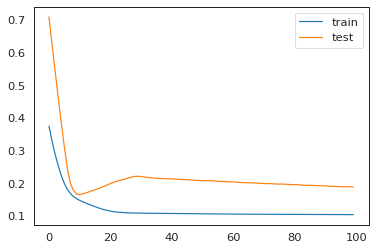

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

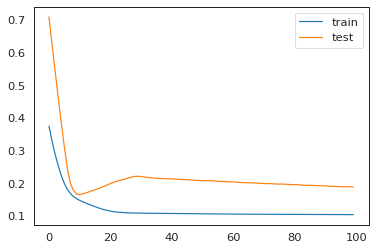

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [ ]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 23)
Test MSE: 0.082
Test RMSE: 0.286
median_absolute_error 0.10487485
mean_absolute_error 0.18952176


## Preprocessing feature selected data for training

In [ ]:
len(LA_combined_data_featured_selected.columns)

11

In [ ]:
values = LA_combined_data_featured_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_feature_selected)-1] = encoder.fit_transform(values[:,len(X_cols_feature_selected)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var9(t)  var10(t)  var11(t)
1     0.0000     0.0000     0.0000  ...   0.0000    0.0033    0.0000
2     0.0000     0.0000     0.0000  ...   0.0000    0.0066    0.0000
3     0.0000     0.0000     0.0000  ...   0.0000    0.0099    0.0002
4     0.0000     0.2729     0.2729  ...   0.0000    0.0132    0.0001
5     0.0000     0.4093     0.4093  ...   0.0000    0.0166    0.0001

[5 rows x 22 columns]


### Train Test split

In [ ]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 22)
(232, 1, 21) (232,) (59, 1, 21) (59,)


### Training LSTM for feature selected data

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/200
4/4 - 3s - loss: 0.0232 - val_loss: 0.1173
Epoch 2/200
4/4 - 0s - loss: 0.0167 - val_loss: 0.1137
Epoch 3/200
4/4 - 0s - loss: 0.0163 - val_loss: 0.1155
Epoch 4/200
4/4 - 0s - loss: 0.0156 - val_loss: 0.1159
Epoch 5/200
4/4 - 0s - loss: 0.0151 - val_loss: 0.1148
Epoch 6/200
4/4 - 0s - loss: 0.0154 - val_loss: 0.1142
Epoch 7/200
4/4 - 0s - loss: 0.0148 - val_loss: 0.1152
Epoch 8/200
4/4 - 0s - loss: 0.0144 - val_loss: 0.1173
Epoch 9/200
4/4 - 0s - loss: 0.0144 - val_loss: 0.1188
Epoch 10/200
4/4 - 0s - loss: 0.0141 - val_loss: 0.1213
Epoch 11/200
4/4 - 0s - loss: 0.0141 - val_loss: 0.1210
Epoch 12/200
4/4 - 0s - loss: 0.0139 - val_loss: 0.1189
Epoch 13/200
4/4 - 0s - loss: 0.0138 - val_loss: 0.1197
Epoch 14/200
4/4 - 0s - loss: 0.0137 - val_loss: 0.1178
Epoch 15/200
4/4 - 0s - loss: 0.0136 - val_loss: 0.1198
Epoch 16/200
4/4 - 0s - loss: 0.0133 - val_loss: 0.1215
Epoch 17/200
4/4 - 0s - loss: 0.0134 - val_loss: 0.1217
Epoch 18/200
4/4 - 0s - loss: 0.0133 - val_loss: 0.1216
E

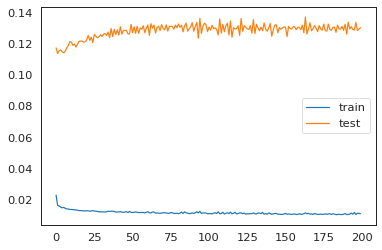

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing feature selected data

In [ ]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 21)
Test MSE: 0.046
Test RMSE: 0.215
median_absolute_error 0.060172074
mean_absolute_error 0.13026224


# LSTM: Mobility Group + Social Distancing + Mask Rule

In [ ]:
x_col_mobility = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person','X..working.from.home','m50_index','Social.distancing.index',
                           'mask_rule_severity','Date','New cases/100k']

x_col_mobility_feature_imp = ['retail_and_recreation_percent_change_from_baseline','Trips.person',
                              'X..working.from.home','parks_percent_change_from_baseline',
                              'X..out.of.county.trips',
                              'X..out.of.state.trips','X..working.from.home','Miles.person',
                              'grocery_and_pharmacy_percent_change_from_baseline','transit_stations_percent_change_from_baseline',
                              'retail_and_recreation_percent_change_from_baseline','m50_index','Social.distancing.index',
                           'mask_rule_severity','Date','New cases/100k']

In [ ]:


X_cols_all = x_col_mobility

X_cols_feature_selected = x_col_mobility_feature_imp


In [ ]:
LA_combined_data_all = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_featured = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_feature_selected]
print(LA_combined_data_featured.shape)
LA_combined_data_all.head(5)

(292, 19)
(292, 16)


,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..working.from.home,m50_index,Social.distancing.index,mask_rule_severity,Date,New cases/100k
4804,4.0000,3.0000,-5.0000,-3.0000,1.0000,0.0000,26,2.9100,11.2000,0.5000,35.1000,0.2600,2.6500,5.7000,60,35,0.0000,2020-03-01,0.0000
4805,5.0000,5.0000,8.0000,1.0000,4.0000,-1.0000,19,3.4200,10.4000,0.4000,35.1000,0.7000,2.7100,5.7000,98,16,0.0000,2020-03-02,0.0000
4806,8.0000,7.0000,32.0000,2.0000,3.0000,-1.0000,18,3.5700,10.2000,0.3000,33.7000,0.7300,2.8400,5.7000,99,15,0.0000,2020-03-03,0.0000
4807,4.0000,6.0000,9.0000,-1.0000,2.0000,0.0000,18,3.4800,10.7000,0.3000,34.9000,0.7200,2.7600,5.7000,100,14,0.0000,2020-03-04,0.0594
4808,4.0000,7.0000,9.0000,0.0000,2.0000,0.0000,18,3.5200,10.7000,0.3000,36.4000,0.7200,2.8100,5.7000,106,14,0.0000,2020-03-05,0.0396


In [ ]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [ ]:
len(LA_combined_data_featured.columns)

16

In [ ]:
LA_combined_data_featured['Date'] = LA_combined_data_featured['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_all['Date'] = LA_combined_data_all['Date'].apply(lambda x: datetime_to_float(x))

#Harris_combined_data.index.name = 'Date'
LA_combined_data_featured.head()

,retail_and_recreation_percent_change_from_baseline,Trips.person,X..working.from.home,parks_percent_change_from_baseline,X..out.of.county.trips,X..out.of.state.trips,X..working.from.home,Miles.person,grocery_and_pharmacy_percent_change_from_baseline,transit_stations_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline,m50_index,Social.distancing.index,mask_rule_severity,Date,New cases/100k
4804,4.0000,2.9100,5.7000,-5.0000,11.2000,0.5000,5.7000,35.1000,3.0000,-3.0000,4.0000,60,35,0.0000,1583020800.0000,0.0000
4805,5.0000,3.4200,5.7000,8.0000,10.4000,0.4000,5.7000,35.1000,5.0000,1.0000,5.0000,98,16,0.0000,1583107200.0000,0.0000
4806,8.0000,3.5700,5.7000,32.0000,10.2000,0.3000,5.7000,33.7000,7.0000,2.0000,8.0000,99,15,0.0000,1583193600.0000,0.0000
4807,4.0000,3.4800,5.7000,9.0000,10.7000,0.3000,5.7000,34.9000,6.0000,-1.0000,4.0000,100,14,0.0000,1583280000.0000,0.0594
4808,4.0000,3.5200,5.7000,9.0000,10.7000,0.3000,5.7000,36.4000,7.0000,0.0000,4.0000,106,14,0.0000,1583366400.0000,0.0396


In [ ]:
print(len(LA_combined_data_featured.columns))
LA_combined_data_featured.dtypes

16


retail_and_recreation_percent_change_from_baseline    float64
Trips.person                                          float64
X..working.from.home                                  float64
parks_percent_change_from_baseline                    float64
X..out.of.county.trips                                float64
X..out.of.state.trips                                 float64
X..working.from.home                                  float64
Miles.person                                          float64
grocery_and_pharmacy_percent_change_from_baseline     float64
transit_stations_percent_change_from_baseline         float64
retail_and_recreation_percent_change_from_baseline    float64
m50_index                                               int64
Social.distancing.index                                 int64
mask_rule_severity                                    float64
Date                                                  float64
New cases/100k                                        float64
dtype: o

## Preprocessing data for LSTM

In [ ]:
LA_combined_data_all_selected = LA_combined_data_all[X_cols_all]
LA_combined_data_featured_selected = LA_combined_data_featured[X_cols_feature_selected]

In [ ]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## All values for CA training data

In [ ]:
values = LA_combined_data_all_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_all)-1] = encoder.fit_transform(values[:,len(X_cols_all)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var17(t)  var18(t)  var19(t)
1     0.9512     0.6092     0.6337  ...    0.0000    0.0033    0.0000
2     0.9634     0.6322     0.7624  ...    0.0000    0.0066    0.0000
3     1.0000     0.6552     1.0000  ...    0.0000    0.0099    0.0186
4     0.9512     0.6437     0.7723  ...    0.0000    0.0132    0.0112
5     0.9512     0.6552     0.7723  ...    0.0000    0.0166    0.0074

[5 rows x 38 columns]


## Train Test Split

In [ ]:
values.shape[0]

292

In [ ]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 38)
(232, 1, 37) (232,) (59, 1, 37) (59,)


## Training LSTM

Epoch 1/100
4/4 - 2s - loss: 0.2636 - val_loss: 0.4703
Epoch 2/100
4/4 - 0s - loss: 0.2053 - val_loss: 0.3645
Epoch 3/100
4/4 - 0s - loss: 0.1981 - val_loss: 0.3201
Epoch 4/100
4/4 - 0s - loss: 0.1983 - val_loss: 0.3239
Epoch 5/100
4/4 - 0s - loss: 0.1955 - val_loss: 0.3475
Epoch 6/100
4/4 - 0s - loss: 0.1931 - val_loss: 0.3764
Epoch 7/100
4/4 - 0s - loss: 0.1928 - val_loss: 0.3996
Epoch 8/100
4/4 - 0s - loss: 0.1933 - val_loss: 0.4057
Epoch 9/100
4/4 - 0s - loss: 0.1911 - val_loss: 0.3960
Epoch 10/100
4/4 - 0s - loss: 0.1866 - val_loss: 0.3798
Epoch 11/100
4/4 - 0s - loss: 0.1828 - val_loss: 0.3638
Epoch 12/100
4/4 - 0s - loss: 0.1795 - val_loss: 0.3529
Epoch 13/100
4/4 - 0s - loss: 0.1773 - val_loss: 0.3554
Epoch 14/100
4/4 - 0s - loss: 0.1760 - val_loss: 0.3615
Epoch 15/100
4/4 - 0s - loss: 0.1743 - val_loss: 0.3598
Epoch 16/100
4/4 - 0s - loss: 0.1718 - val_loss: 0.3541
Epoch 17/100
4/4 - 0s - loss: 0.1692 - val_loss: 0.3487
Epoch 18/100
4/4 - 0s - loss: 0.1665 - val_loss: 0.3453
E

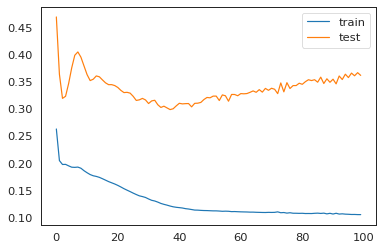

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

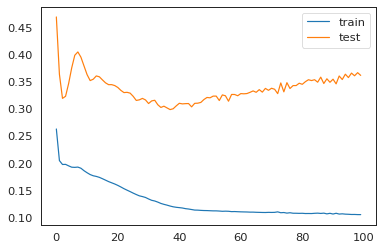

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [ ]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 37)
Test MSE: 0.159
Test RMSE: 0.399
median_absolute_error 0.38914627
mean_absolute_error 0.36243197


## Preprocessing feature selected data for training

In [ ]:
len(LA_combined_data_featured_selected.columns)

20

In [ ]:
values = LA_combined_data_featured_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_feature_selected)-1] = encoder.fit_transform(values[:,len(X_cols_feature_selected)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var18(t)  var19(t)  var20(t)
1     0.9512     0.9512     0.6154  ...    0.0000    0.0033    0.0000
2     0.9634     0.9634     0.8956  ...    0.0000    0.0066    0.0000
3     1.0000     1.0000     0.9780  ...    0.0000    0.0099    0.0002
4     0.9512     0.9512     0.9286  ...    0.0000    0.0132    0.0001
5     0.9512     0.9512     0.9505  ...    0.0000    0.0166    0.0001

[5 rows x 40 columns]


### Train Test split

In [ ]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 40)
(232, 1, 39) (232,) (59, 1, 39) (59,)


### Training LSTM for feature selected data

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/200
4/4 - 2s - loss: 0.0358 - val_loss: 0.1908
Epoch 2/200
4/4 - 0s - loss: 0.0506 - val_loss: 0.1870
Epoch 3/200
4/4 - 0s - loss: 0.0278 - val_loss: 0.1496
Epoch 4/200
4/4 - 0s - loss: 0.0296 - val_loss: 0.1849
Epoch 5/200
4/4 - 0s - loss: 0.0260 - val_loss: 0.1645
Epoch 6/200
4/4 - 0s - loss: 0.0253 - val_loss: 0.1562
Epoch 7/200
4/4 - 0s - loss: 0.0198 - val_loss: 0.1781
Epoch 8/200
4/4 - 0s - loss: 0.0238 - val_loss: 0.1618
Epoch 9/200
4/4 - 0s - loss: 0.0195 - val_loss: 0.1705
Epoch 10/200
4/4 - 0s - loss: 0.0197 - val_loss: 0.1688
Epoch 11/200
4/4 - 0s - loss: 0.0189 - val_loss: 0.1719
Epoch 12/200
4/4 - 0s - loss: 0.0187 - val_loss: 0.1676
Epoch 13/200
4/4 - 0s - loss: 0.0201 - val_loss: 0.1722
Epoch 14/200
4/4 - 0s - loss: 0.0187 - val_loss: 0.1686
Epoch 15/200
4/4 - 0s - loss: 0.0209 - val_loss: 0.1669
Epoch 16/200
4/4 - 0s - loss: 0.0179 - val_loss: 0.1716
Epoch 17/200
4/4 - 0s - loss: 0.0207 - val_loss: 0.1656
Epoch 18/200
4/4 - 0s - loss: 0.0176 - val_loss: 0.1750
E

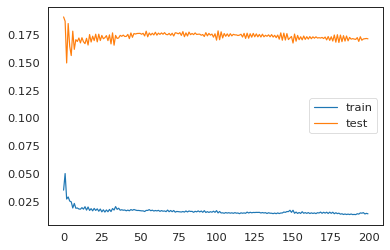

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing feature selected data

In [ ]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 39)
Test MSE: 0.061
Test RMSE: 0.246
median_absolute_error 0.11353008
mean_absolute_error 0.1711982


# LSTM: All Groups Together

In [ ]:
x_col_all_group = ['FIPS','mask_rule_severity','m50_index','retail_and_recreation_percent_change_from_baseline',
                'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline',
                'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',
                'residential_percent_change_from_baseline','PopDensity','Social.distancing.index',
                'X..staying.home','Trips.person','X..out.of.county.trips',	'X..out.of.state.trips',
                'Miles.person',	'Work.trips.person','Non.work.trips.person','X..change.in.consumption',
                'Transit.mode.share','X..people.older.than.60',	'Median.income',	'X..African.Americans',
                'X..Hispanic.Americans',	'X..Male','Employment.density',	'X..hot.spots.1000.people',
                'Hospital.beds.1000.people',	'ICUs.1000.people',
                'New.cases.1000.people',	'Active.cases.1000.people',	'X.days..decreasing.COVID.cases',
                'X..hospital.bed.utilization',	'Testing.capacity',	'Tests.done.1000.people',	'X..ICU.utilization',
                'Ventilator.shortage',	'Imported.COVID.cases',	'COVID.exposure.1000.people',	'X.days..decreasing.ILI.cases',
                'Unemployment.claims.1000.people',	'Unemployment.rate',	'X..working.from.home',
                'Cumulative.inflation.rate'	,'COVID.death.rate','growth_code',
                	'positivity_rate',	'rolling_avg_new_cases/100k','Date','New cases/100k']
  

X_cols_all = x_col_all_group

X_cols_feature_selected = ['Tests.done.1000.people',
 'X..staying.home','Unemployment.rate',
 'X..people.older.than.60','X..working.from.home','X.days..decreasing.ILI.cases',
 'X..Male','X..out.of.county.trips','parks_percent_change_from_baseline',
 'Work.trips.person','m50_index','FIPS','positivity_rate','Imported.COVID.cases',
 'X..out.of.state.trips','Miles.person',
 'X.days..decreasing.COVID.cases','grocery_and_pharmacy_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'Testing.capacity','retail_and_recreation_percent_change_from_baseline','Unemployment.claims.1000.people',
 'growth_code','Date','New cases/100k']


In [ ]:
print(len(X_cols_feature_selected))
len(x_col_all_group)

25


50

In [ ]:
LA_combined_data_all = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_featured = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_feature_selected]
print(LA_combined_data_featured.shape)
LA_combined_data_all.head(5)

(292, 50)
(292, 25)


,FIPS,mask_rule_severity,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,growth_code,positivity_rate,rolling_avg_new_cases/100k,Date,New cases/100k
4804,6037,0.0000,60,4.0000,3.0000,-5.0000,-3.0000,1.0000,0.0000,960.7428,35,26,2.9100,11.2000,0.5000,35.1000,0.2600,2.6500,-4.2000,6.0400,18,64251,7.9000,48.5000,49.2800,972,140,2.0500,0.2200,0.0000,0.0000,29,54.0000,0.0000,0.0000,0.0000,0,0,0.0500,35,1.1000,5.3000,5.7000,0.6000,0.0000,0,0.0000,0.0000,2020-03-01,0.0000
4805,6037,0.0000,98,5.0000,5.0000,8.0000,1.0000,4.0000,-1.0000,960.7428,16,19,3.4200,10.4000,0.4000,35.1000,0.7000,2.7100,-2.0000,6.0400,18,64251,7.9000,48.5000,49.2800,972,140,2.0500,0.2200,0.0000,0.0000,30,54.0000,0.0000,0.0000,0.0000,0,1,0.0500,35,1.1000,5.3000,5.7000,0.6000,0.0000,0,0.0000,0.0000,2020-03-02,0.0000
4806,6037,0.0000,99,8.0000,7.0000,32.0000,2.0000,3.0000,-1.0000,960.7428,15,18,3.5700,10.2000,0.3000,33.7000,0.7300,2.8400,2.7000,6.0400,18,64251,7.9000,48.5000,49.2800,972,140,2.0500,0.2200,0.0000,0.0000,31,54.0000,0.0000,0.0000,0.0000,0,1,0.0500,42,1.1000,5.3000,5.7000,0.6000,0.0000,0,0.0000,0.0000,2020-03-03,0.0000
4807,6037,0.0000,100,4.0000,6.0000,9.0000,-1.0000,2.0000,0.0000,960.7428,14,18,3.4800,10.7000,0.3000,34.9000,0.7200,2.7600,-0.2000,6.0400,18,64251,7.9000,48.5000,49.2800,972,140,2.0500,0.2200,0.0002,0.0000,0,54.0000,10.3000,0.0100,0.0000,0,1,0.0600,42,1.1000,5.3000,5.7000,0.6000,0.0400,0,0.0020,0.0000,2020-03-04,0.0594
4808,6037,0.0000,106,4.0000,7.0000,9.0000,0.0000,2.0000,0.0000,960.7428,14,18,3.5200,10.7000,0.3000,36.4000,0.7200,2.8100,1.6000,6.0400,18,64251,7.9000,48.5000,49.2800,972,140,2.0500,0.2200,0.0003,0.0000,0,54.0000,10.3000,0.0100,0.0000,0,2,0.0600,42,1.1000,5.3000,5.7000,0.6000,0.0400,0,0.0030,0.0000,2020-03-05,0.0396


In [ ]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [ ]:
len(LA_combined_data_featured.columns)

25

In [ ]:
LA_combined_data_featured['Date'] = LA_combined_data_featured['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_all['Date'] = LA_combined_data_all['Date'].apply(lambda x: datetime_to_float(x))

#Harris_combined_data.index.name = 'Date'
LA_combined_data_featured.head()

,Tests.done.1000.people,X..staying.home,Unemployment.rate,X..people.older.than.60,X..working.from.home,X.days..decreasing.ILI.cases,X..Male,X..out.of.county.trips,parks_percent_change_from_baseline,Work.trips.person,m50_index,FIPS,positivity_rate,Imported.COVID.cases,X..out.of.state.trips,Miles.person,X.days..decreasing.COVID.cases,grocery_and_pharmacy_percent_change_from_baseline,transit_stations_percent_change_from_baseline,Testing.capacity,retail_and_recreation_percent_change_from_baseline,Unemployment.claims.1000.people,growth_code,Date,New cases/100k
4804,0.0000,26,5.3000,18,5.7000,35,49.2800,11.2000,-5.0000,0.2600,60,6037,0.0000,0,0.5000,35.1000,29,3.0000,-3.0000,0.0000,4.0000,1.1000,0,1583020800.0000,0.0000
4805,0.0000,19,5.3000,18,5.7000,35,49.2800,10.4000,8.0000,0.7000,98,6037,0.0000,1,0.4000,35.1000,30,5.0000,1.0000,0.0000,5.0000,1.1000,0,1583107200.0000,0.0000
4806,0.0000,18,5.3000,18,5.7000,42,49.2800,10.2000,32.0000,0.7300,99,6037,0.0000,1,0.3000,33.7000,31,7.0000,2.0000,0.0000,8.0000,1.1000,0,1583193600.0000,0.0000
4807,0.0100,18,5.3000,18,5.7000,42,49.2800,10.7000,9.0000,0.7200,100,6037,0.0020,1,0.3000,34.9000,0,6.0000,-1.0000,10.3000,4.0000,1.1000,0,1583280000.0000,0.0594
4808,0.0100,18,5.3000,18,5.7000,42,49.2800,10.7000,9.0000,0.7200,106,6037,0.0030,2,0.3000,36.4000,0,7.0000,0.0000,10.3000,4.0000,1.1000,0,1583366400.0000,0.0396


In [ ]:
print(len(LA_combined_data_featured.columns))
LA_combined_data_featured.dtypes

25


Tests.done.1000.people                                float64
X..staying.home                                         int64
Unemployment.rate                                     float64
X..people.older.than.60                                 int64
X..working.from.home                                  float64
X.days..decreasing.ILI.cases                            int64
X..Male                                               float64
X..out.of.county.trips                                float64
parks_percent_change_from_baseline                    float64
Work.trips.person                                     float64
m50_index                                               int64
FIPS                                                    int64
positivity_rate                                       float64
Imported.COVID.cases                                    int64
X..out.of.state.trips                                 float64
Miles.person                                          float64
X.days..

## Preprocessing data for LSTM

In [ ]:
LA_combined_data_all_selected = LA_combined_data_all[X_cols_all]
LA_combined_data_featured_selected = LA_combined_data_featured[X_cols_feature_selected]

In [ ]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## All values for CA training data

In [ ]:
values = LA_combined_data_all_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_all)-1] = encoder.fit_transform(values[:,len(X_cols_all)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var48(t)  var49(t)  var50(t)
1     0.0000     0.0000     0.5405  ...    0.0000    0.0033    0.0000
2     0.0000     0.0000     0.8829  ...    0.0000    0.0066    0.0000
3     0.0000     0.0000     0.8919  ...    0.0000    0.0099    0.0186
4     0.0000     0.0000     0.9009  ...    0.0000    0.0132    0.0112
5     0.0000     0.0000     0.9550  ...    0.0000    0.0166    0.0074

[5 rows x 100 columns]


## Train Test Split

In [ ]:
values.shape[0]

292

In [ ]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 100)
(232, 1, 99) (232,) (59, 1, 99) (59,)


## Training LSTM

Epoch 1/100
4/4 - 2s - loss: 0.3065 - val_loss: 0.4339
Epoch 2/100
4/4 - 0s - loss: 0.1990 - val_loss: 0.2569
Epoch 3/100
4/4 - 0s - loss: 0.1907 - val_loss: 0.1878
Epoch 4/100
4/4 - 0s - loss: 0.1902 - val_loss: 0.1952
Epoch 5/100
4/4 - 0s - loss: 0.1781 - val_loss: 0.2341
Epoch 6/100
4/4 - 0s - loss: 0.1699 - val_loss: 0.2726
Epoch 7/100
4/4 - 0s - loss: 0.1677 - val_loss: 0.2837
Epoch 8/100
4/4 - 0s - loss: 0.1627 - val_loss: 0.2652
Epoch 9/100
4/4 - 0s - loss: 0.1523 - val_loss: 0.2251
Epoch 10/100
4/4 - 0s - loss: 0.1408 - val_loss: 0.1803
Epoch 11/100
4/4 - 0s - loss: 0.1313 - val_loss: 0.1607
Epoch 12/100
4/4 - 0s - loss: 0.1244 - val_loss: 0.1556
Epoch 13/100
4/4 - 0s - loss: 0.1180 - val_loss: 0.1608
Epoch 14/100
4/4 - 0s - loss: 0.1131 - val_loss: 0.1696
Epoch 15/100
4/4 - 0s - loss: 0.1106 - val_loss: 0.1756
Epoch 16/100
4/4 - 0s - loss: 0.1077 - val_loss: 0.1786
Epoch 17/100
4/4 - 0s - loss: 0.1043 - val_loss: 0.1835
Epoch 18/100
4/4 - 0s - loss: 0.1020 - val_loss: 0.1903
E

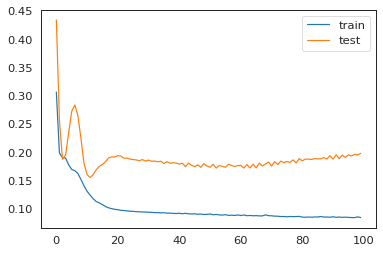

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

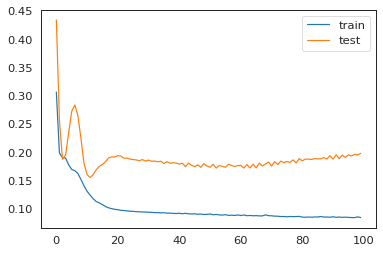

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [ ]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 99)
Test MSE: 0.065
Test RMSE: 0.254
median_absolute_error 0.16524887
mean_absolute_error 0.1984019


## Preprocessing feature selected data for training

In [ ]:
len(LA_combined_data_featured_selected.columns)

25

In [ ]:
values = LA_combined_data_featured_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_feature_selected)-1] = encoder.fit_transform(values[:,len(X_cols_feature_selected)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var23(t)  var24(t)  var25(t)
1     0.0000     0.2353     0.0000  ...    0.0000    0.0033    0.0000
2     0.0000     0.0294     0.0000  ...    0.0000    0.0066    0.0000
3     0.0000     0.0000     0.0000  ...    0.0000    0.0099    0.0186
4     0.0000     0.0000     0.0000  ...    0.0000    0.0132    0.0112
5     0.0000     0.0000     0.0000  ...    0.0000    0.0166    0.0074

[5 rows x 50 columns]


### Train Test split

In [ ]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 50)
(232, 1, 49) (232,) (59, 1, 49) (59,)


### Training LSTM for feature selected data

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/200
4/4 - 2s - loss: 0.3100 - val_loss: 0.5732
Epoch 2/200
4/4 - 0s - loss: 0.2249 - val_loss: 0.4433
Epoch 3/200
4/4 - 0s - loss: 0.1913 - val_loss: 0.3485
Epoch 4/200
4/4 - 0s - loss: 0.1848 - val_loss: 0.2968
Epoch 5/200
4/4 - 0s - loss: 0.1834 - val_loss: 0.2861
Epoch 6/200
4/4 - 0s - loss: 0.1779 - val_loss: 0.3006
Epoch 7/200
4/4 - 0s - loss: 0.1714 - val_loss: 0.3174
Epoch 8/200
4/4 - 0s - loss: 0.1660 - val_loss: 0.3297
Epoch 9/200
4/4 - 0s - loss: 0.1617 - val_loss: 0.3324
Epoch 10/200
4/4 - 0s - loss: 0.1569 - val_loss: 0.3259
Epoch 11/200
4/4 - 0s - loss: 0.1513 - val_loss: 0.3131
Epoch 12/200
4/4 - 0s - loss: 0.1456 - val_loss: 0.2964
Epoch 13/200
4/4 - 0s - loss: 0.1398 - val_loss: 0.2757
Epoch 14/200
4/4 - 0s - loss: 0.1336 - val_loss: 0.2524
Epoch 15/200
4/4 - 0s - loss: 0.1274 - val_loss: 0.2306
Epoch 16/200
4/4 - 0s - loss: 0.1225 - val_loss: 0.2143
Epoch 17/200
4/4 - 0s - loss: 0.1180 - val_loss: 0.2037
Epoch 18/200
4/4 - 0s - loss: 0.1140 - val_loss: 0.1979
E

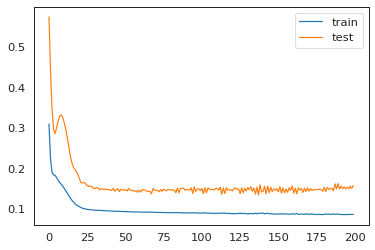

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing feature selected data

In [ ]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 49)
Test MSE: 0.041
Test RMSE: 0.203
median_absolute_error 0.15570676
mean_absolute_error 0.15823865


# Conclusion for all dataset after PCA

|Group | data | MSE  |RMSE  |Median AE  |MAE|
|------|------|------|-----|------|-----|
|Demographic |without PCA  | 0.042| 0.204|0.0981|0.1333|
|Demographic |with PCA  | 0.049| 0.220|0.0909|0.1385|
|Hospitalization & Testing |without PCA | 0.042| 0.204|0.0981|0.1333|
|Hospitalization & Testing |with PCA  | 0.046| 0.215|0.06017|0.1302|
|Mobility+Social Distancing + Mask Rule |without PCA | 0.159| 0.399|0.3891|0.3624|
|Mobility+Social Distancing + Mask Rule |with PCA  | 0.061| 0.246|0.1135|0.1171|
|All Groups Together |without PCA | 0.065| 0.254|0.1652|0.1984|
|All Groups Together |with PCA  | 0.041| 0.203|0.1557|0.1582|











**Summary**:

We have applied LSTM for each group with and without PCA

For ***demographic*** group, we originally had 8 features and after PCA 6 features are selected for processing. 
>* *Observation*: Error had increased after PCA filteration

For **Hospitalization and testing**, we originally had 11 features, after PCA we selected 7 features for processing

>* *Observation*: MSE error got increased and sbsolute errors got reduced

For **mobility +social distancing + mask rule**, We have applied LSTM for mobility +social distancing + mask rule groups together because social distancing and mask rule have very few columns. Totally: 15 features and 12 features are selected for processing. 

>* *Observation*: errors got decreased after PCA

For **All Data**, totally 51 features, after filtering 28 features using PCA. 

>* *Observation*: We noticed a significant reduction in all the errors




